In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds
import os
import numpy as np
import time
from IPython.display import clear_output

In [4]:
import tensorflow_addons as tfa
from tensorflow_addons.layers import InstanceNormalization

In [5]:
# !pip install git+https://www.github.com/keras-team/keras-contrib.git
# clear_output()
# from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

In [20]:
base_dir = '../../data/gan-getting-started'

monet_dir = os.path.join(base_dir, 'monet_jpg')
photo_dir = os.path.join(base_dir, 'photo_jpg')

img_height = 256
img_width = 256
n_channels = 3

img_shape = (img_height, img_width, n_channels)
batch_size = 1
EPOCHS = 20

In [22]:
normalization_layer = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)

train_monet = tf.keras.utils.image_dataset_from_directory(monet_dir,
                                                          validation_split=0.2,
                                                          labels=None,
                                                          subset="training",
                                                          seed=123,
                                                          interpolation='nearest',
                                                          image_size=(img_height, img_width),
                                                          batch_size=batch_size)

test_monet = tf.keras.utils.image_dataset_from_directory(monet_dir,
                                                         validation_split=0.2,
                                                         labels=None,
                                                         subset="validation",
                                                         seed=123,
                                                         interpolation='nearest',
                                                         image_size=(img_height, img_width),
                                                         batch_size=batch_size)

train_photo = tf.keras.utils.image_dataset_from_directory(photo_dir,
                                                          validation_split=0.2,
                                                          labels=None,
                                                          subset="training",
                                                          seed=123,
                                                          interpolation='nearest',
                                                          image_size=(img_height, img_width),
                                                          batch_size=batch_size)

test_photo = tf.keras.utils.image_dataset_from_directory(photo_dir,
                                                         validation_split=0.2,
                                                         labels=None,
                                                         subset="validation",
                                                         seed=123,
                                                         interpolation='nearest',
                                                         image_size=(img_height, img_width),
                                                         batch_size=batch_size)


train_monet = train_monet.repeat().map(lambda x: normalization_layer(x))
test_monet = test_monet.map(lambda x: normalization_layer(x))
train_photo = train_photo.map(lambda x: normalization_layer(x))
test_photo = test_photo.map(lambda x: normalization_layer(x))

Found 300 files belonging to 1 classes.
Using 240 files for training.
Found 300 files belonging to 1 classes.
Using 60 files for validation.
Found 7038 files belonging to 1 classes.
Using 5631 files for training.
Found 7038 files belonging to 1 classes.
Using 1407 files for validation.


(256, 256, 3)


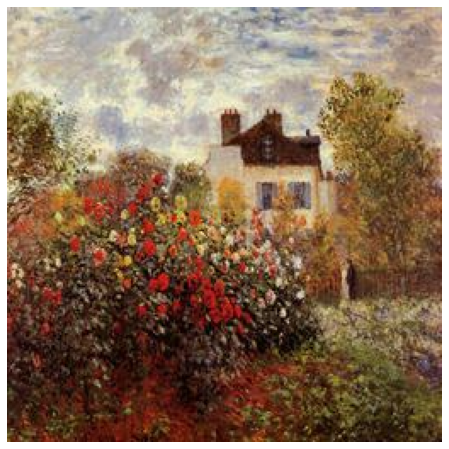

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images in train_monet.take(1):
    print(images[0].shape)
    plt.imshow(images[0].numpy() * 0.5 + 0.5)
    plt.axis("off")

(256, 256, 3)


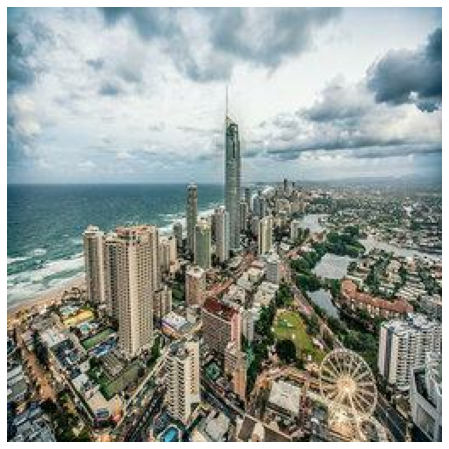

In [24]:
plt.figure(figsize=(8, 8))
for images in train_photo.take(1):
    print(images[0].shape)
    plt.imshow(images[0].numpy() * 0.5 + 0.5)
    plt.axis("off")

In [25]:
def u_net(input_shape, init_filters=32, kernel_size=4, activation='relu', name='gen'):
    kernel_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=42)
    inp = layers.Input(shape=input_shape)
    x = inp
    
    filters = init_filters
    
    branches = []
    depth = 0
    
    while True:
        if K.int_shape(x)[1] != (K.int_shape(x)[1] // 2) * 2 or K.int_shape(x)[1] == 2:
            break
        
        x = layers.Conv2D(filters=filters, kernel_size=kernel_size, padding='same',
                          kernel_initializer=kernel_init, strides=2, use_bias=False)(x)
        
        x = InstanceNormalization()(x)
        x = layers.Activation(activation)(x) if activation != 'leaky_relu' else layers.LeakyReLU(0.2)(x)
        
        filters *= 2 if depth%2 == 0 else 1
        branches.append(x)
        depth += 1
    
    prev_shape = K.int_shape(x)
    x = layers.Flatten()(x)
    x = layers.Dense(K.int_shape(x)[-1])(x)
    x = layers.Reshape((prev_shape[1:]))(x)
    
    branches = list(reversed(branches))
    
    for d in range(depth):
        depth -= 1
        filters //=2 if depth%2 == 0 else 1
        to_stride = 1 if K.int_shape(branches[d])[1] == K.int_shape(x)[1] else 2
        
        x = layers.Conv2DTranspose(filters=filters, kernel_size= kernel_size, padding='same',
                                   kernel_initializer=kernel_init, strides=to_stride, use_bias=False)(x)
        
        x = layers.Concatenate()([branches[d], x])
        x = InstanceNormalization()(x)
        x = layers.Activation(activation)(x) if activation != 'leaky_relu' else layers.LeakyReLU(0.2)(x)
        
    x = layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, padding='same', strides=2, use_bias=False)(x)
    x = layers.Activation(activation)(x) if activation != 'leaky_relu' else layers.LeakyReLU(0.2)(x)
    
    out = layers.Conv2D(input_shape[-1], kernel_size=kernel_size, padding='same', use_bias=False)(x)
#     out = layers.Activation('sigmoid')(x)

    
    return Model(inp, out, name=name)

In [26]:
def vgg(input_shape, init_filters=32, kernel_size=4, activation='relu', name='dis'):
    kernel_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=42)

    inp = layers.Input(shape=input_shape)
    x = inp
    
    filters = init_filters
    depth = 0
    
    while True:
        if K.int_shape(x)[1] != (K.int_shape(x)[1] // 2) * 2 or K.int_shape(x)[1] == 2:
            break
        
        x = layers.Conv2D(filters=filters, kernel_size=kernel_size, padding='same',
                          kernel_initializer=kernel_init, strides=2)(x)
        
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x) if activation != 'leaky_relu' else layers.LeakyReLU(0.2)(x)
        
        filters *= 2 if depth%2 == 0 else 1
        depth += 1

    out = layers.Conv2D(input_shape[-1], kernel_size=kernel_size, kernel_initializer=kernel_init, padding='same')(x)
#     patch_size = K.int_shape(x)
    
#     x = layers.Reshape((patch_size[1], patch_size[2]))(x)
#     out = layers.Activation('sigmoid')(x)
    
    
    return Model(inp, out, name=name)

In [27]:
generator_g  = u_net(img_shape, activation='leaky_relu', name='gen_monet')
# generator_g.summary()

In [28]:
generator_f  = u_net(img_shape, activation='leaky_relu', name='gen_photo')
# generator_f.summary()

In [29]:
discriminator_x  = vgg(img_shape, activation='leaky_relu', name='dis_monet')
# discriminator_x.summary()

In [30]:
discriminator_y  = vgg(img_shape, activation='leaky_relu', name='dis_photo')
# discriminator_y.summary()

In [31]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [32]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [33]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [34]:
def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(8, 8))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        
        plt.axis('off')
    plt.show()

In [35]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


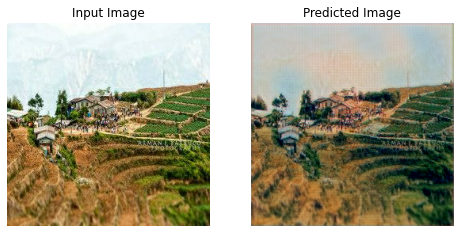

Saving checkpoint for epoch 20 at ./checkpoints/train\ckpt-10
Time taken for epoch 20 is 563.3347275257111 sec



In [36]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_photo, train_monet)):
        train_step(image_x, image_y)

        if n % 100 == 0:
            print ('.', end='')
        n += 1

    

    if (epoch + 1) % 2 == 0:
        clear_output()
        # Using a consistent image (sample_horse) so that the progress of the model
        # is clearly visible.
        for images in test_photo.take(1):
            generate_images(generator_g, images)
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


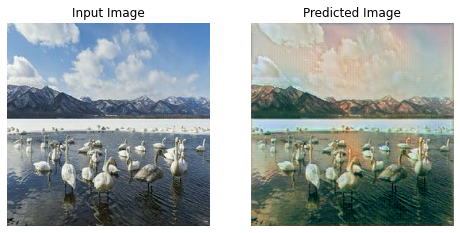

In [44]:
image = iter(test_photo).next()
generate_images(generator_g, image)    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


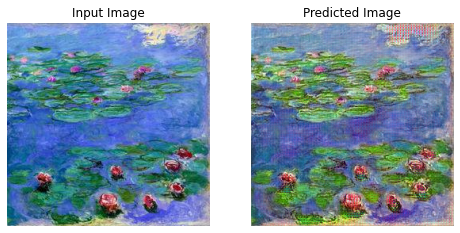

In [48]:
image = iter(test_monet).next()
generate_images(generator_f, image)    